# Anomaly Detection and Event Prediction in Sensor Networks

In [27]:
# Importing all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Data Collection

In [2]:
an_dt = pd.read_csv("data (1).csv")
an_dt

,Area,Sensing Range,Transmission Range,Number of Sensor nodes,Number of Barriers
0,5000,15,30,100,30
1,5000,16,32,112,35
2,5000,17,34,124,42
3,5000,18,36,136,48
4,5000,19,38,148,56
...,...,...,...,...,...
177,50000,36,72,352,101
178,50000,37,74,364,107
179,50000,38,76,376,114
180,50000,39,78,388,121


# Data Preparation

In [3]:
# Check for missing values
missing_values = an_dt.isnull().sum()
print("Missing values per column:")
print(missing_values)

Missing values per column:
Area                      0
Sensing Range             0
Transmission Range        0
Number of Sensor nodes    0
Number of Barriers        0
dtype: int64


In [4]:
# Calculate Z-score for each numeric column
z_scores = np.abs((an_dt - an_dt.mean()) / an_dt.std())

# Define a threshold for outliers (typically z_score > 3 or 2.5 is considered an outlier)
threshold = 3

# Identify outliers
outliers = an_dt[z_scores > threshold]

# Print outliers
print("Identified outliers:")
print(outliers)

Identified outliers:
     Area  Sensing Range  Transmission Range  Number of Sensor nodes  \
0     NaN            NaN                 NaN                     NaN   
1     NaN            NaN                 NaN                     NaN   
2     NaN            NaN                 NaN                     NaN   
3     NaN            NaN                 NaN                     NaN   
4     NaN            NaN                 NaN                     NaN   
..    ...            ...                 ...                     ...   
177   NaN            NaN                 NaN                     NaN   
178   NaN            NaN                 NaN                     NaN   
179   NaN            NaN                 NaN                     NaN   
180   NaN            NaN                 NaN                     NaN   
181   NaN            NaN                 NaN                     NaN   

     Number of Barriers  
0                   NaN  
1                   NaN  
2                   NaN  
3         

In [5]:
# Assuming 'an_dt' is your DataFrame containing the data
an_dt_normalized = an_dt.copy()

# Select columns to normalize (assuming all are numeric except 'Area')
columns_to_normalize = ['Sensing Range', 'Transmission Range', 'Number of Sensor nodes', 'Number of Barriers']

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Apply normalization to selected columns
an_dt_normalized[columns_to_normalize] = scaler.fit_transform(an_dt[columns_to_normalize])

# Feature Engineering

In [6]:
an_dt_fe = an_dt.copy()

# Calculate rate of change in number of barriers
an_dt_fe['Barrier_Change_Rate'] = an_dt_fe['Number of Barriers'].diff()

# Replace the first NaN value (resulting from .diff()) with 0
an_dt_fe['Barrier_Change_Rate'].fillna(0, inplace=True)


scaler = MinMaxScaler()
an_dt_fe[['Barrier_Change_Rate']] = scaler.fit_transform(an_dt_fe[['Barrier_Change_Rate']])

# Print the updated DataFrame with new features
print(an_dt_fe.head())

   Area  Sensing Range  Transmission Range  Number of Sensor nodes  \
0  5000             15                  30                     100   
1  5000             16                  32                     112   
2  5000             17                  34                     124   
3  5000             18                  36                     136   
4  5000             19                  38                     148   

   Number of Barriers  Barrier_Change_Rate  
0                  30             0.942675  
1                  35             0.958599  
2                  42             0.964968  
3                  48             0.961783  
4                  56             0.968153  


# Exploratory Data Analysis (EDA)

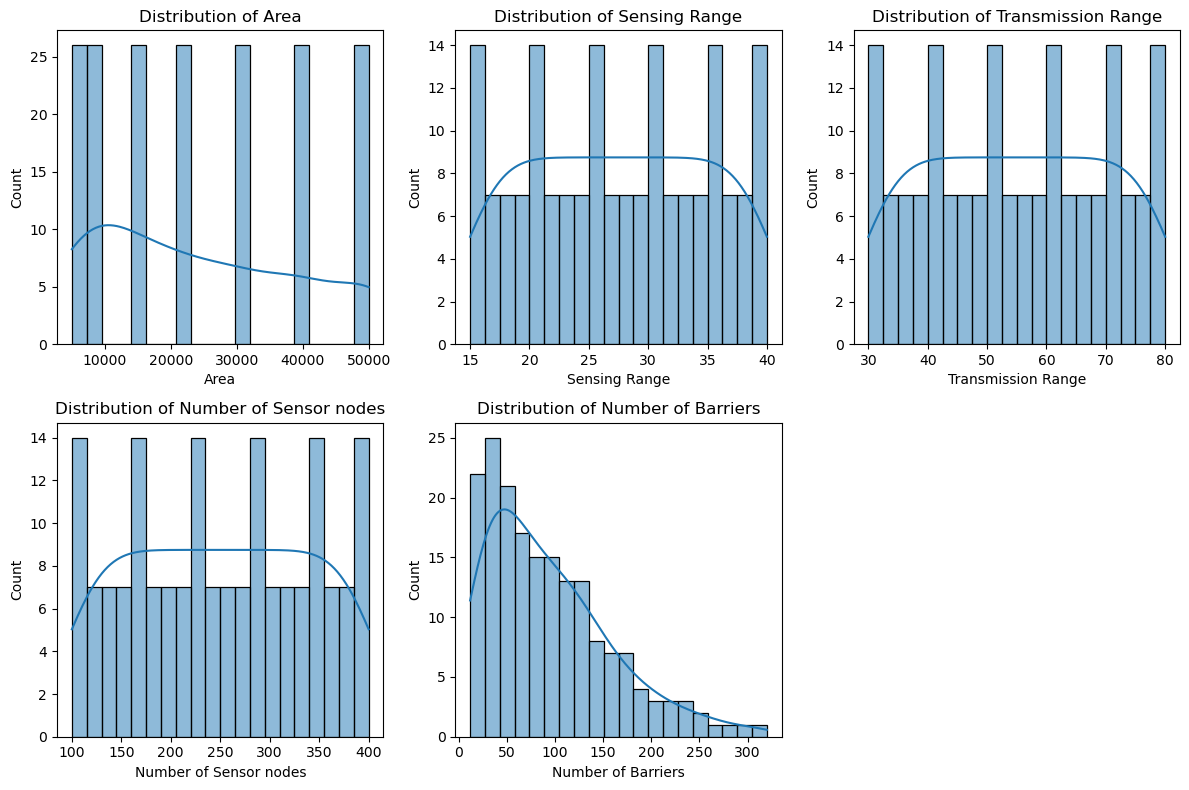

In [7]:
# Plot distributions of each column
plt.figure(figsize=(12, 8))
for i, column in enumerate(an_dt.columns):
    plt.subplot(2, 3, i + 1)
    sns.histplot(an_dt[column], bins=20, kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

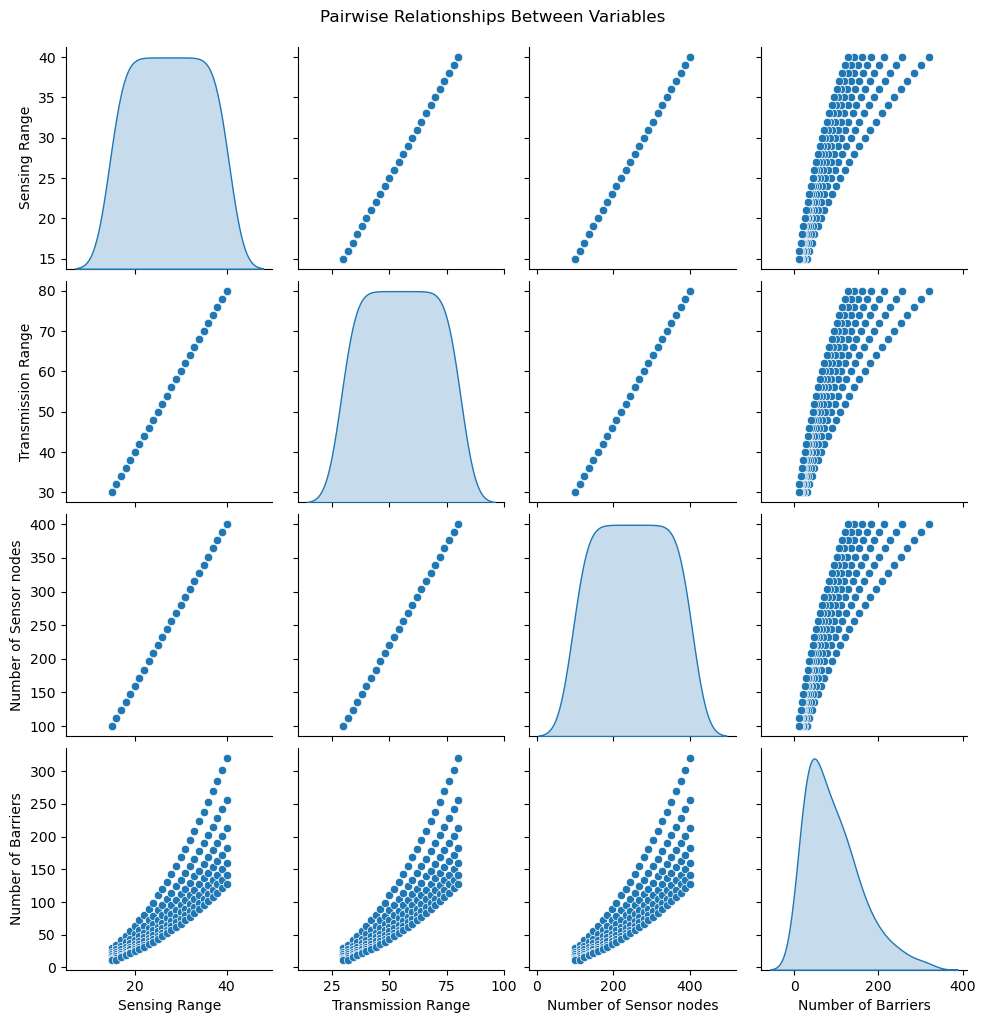

In [8]:
# Pairwise scatter plots for selected variables
sns.pairplot(an_dt, vars=['Sensing Range', 'Transmission Range', 'Number of Sensor nodes', 'Number of Barriers'], diag_kind='kde')
plt.suptitle('Pairwise Relationships Between Variables', y=1.02)
plt.show()

In [9]:
# Compute summary statistics (mean, median, standard deviation)
summary_stats = an_dt.describe()

# Optionally, you can also compute median separately
median = an_dt.median()

# Print summary statistics
print("Summary Statistics:")
print(summary_stats)

# Print median values
print("\nMedian Values:")
print(median)

Summary Statistics:
               Area  Sensing Range  Transmission Range  \
count    182.000000      182.00000          182.000000   
mean   24375.000000       27.50000           55.000000   
std    15197.252769        7.52069           15.041379   
min     5000.000000       15.00000           30.000000   
25%     9375.000000       21.00000           42.000000   
50%    21875.000000       27.50000           55.000000   
75%    39375.000000       34.00000           68.000000   
max    50000.000000       40.00000           80.000000   

       Number of Sensor nodes  Number of Barriers  
count              182.000000          182.000000  
mean               250.000000           94.071429  
std                 90.248276           65.171006  
min                100.000000           12.000000  
25%                172.000000           42.000000  
50%                250.000000           80.000000  
75%                328.000000          128.750000  
max                400.000000          32


Correlation Matrix:
                                Area  Sensing Range  Transmission Range  \
Area                    1.000000e+00   3.095077e-16        3.095077e-16   
Sensing Range           3.095077e-16   1.000000e+00        1.000000e+00   
Transmission Range      3.095077e-16   1.000000e+00        1.000000e+00   
Number of Sensor nodes -1.162999e-16   1.000000e+00        1.000000e+00   
Number of Barriers     -4.234383e-01   8.383655e-01        8.383655e-01   

                        Number of Sensor nodes  Number of Barriers  
Area                             -1.162999e-16           -0.423438  
Sensing Range                     1.000000e+00            0.838365  
Transmission Range                1.000000e+00            0.838365  
Number of Sensor nodes            1.000000e+00            0.838365  
Number of Barriers                8.383655e-01            1.000000  


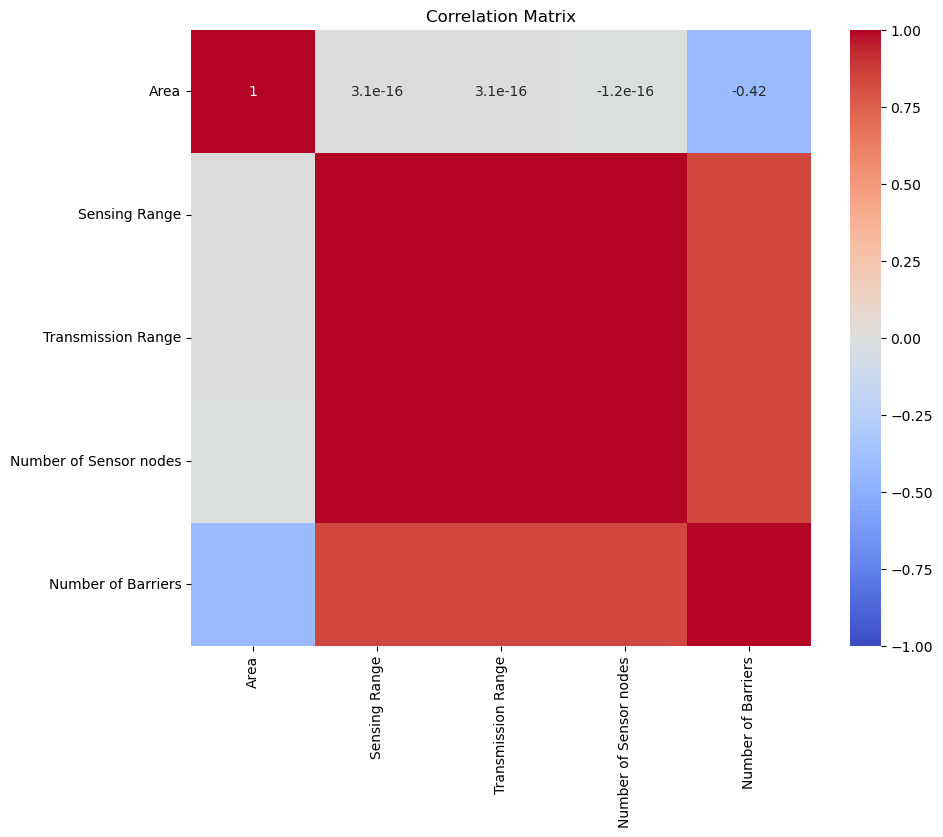

In [10]:
# Calculate correlations
correlation_matrix = an_dt.corr()

# Print correlation matrix
print("\nCorrelation Matrix:")
print(correlation_matrix)

# Plot correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

# Anomaly Detection

In [11]:
# Calculate Z-scores for each column
z_scores = np.abs((an_dt - an_dt.mean()) / an_dt.std())

# Define a threshold for anomalies
threshold = 3

# Identify anomalies using Z-scores
anomalies_zscore = an_dt[z_scores > threshold]

In [12]:
# Calculate moving average
window_size = 3  # Adjust window size as needed
moving_avg = an_dt.rolling(window=window_size).mean()

# Detect anomalies by comparing actual values with moving average
anomalies_moving_avg = an_dt[an_dt > moving_avg + threshold]

In [13]:
# Initialize Isolation Forest model
clf_isoforest = IsolationForest(random_state=0, contamination=0.1)  # Adjust contamination as needed

# Fit model and predict anomalies
anomalies_isoforest = clf_isoforest.fit_predict(an_dt)
anomalies_isoforest = an_dt[anomalies_isoforest == -1]

In [14]:
# Initialize One-Class SVM model
clf_oneclasssvm = OneClassSVM(nu=0.1)  # Adjust nu (analogous to contamination) as needed

# Fit model and predict anomalies
anomalies_oneclasssvm = clf_oneclasssvm.fit_predict(an_dt)
anomalies_oneclasssvm = an_dt[anomalies_oneclasssvm == -1]

In [15]:
# Define autoencoder architecture
input_dim = an_dt.shape[1]
encoding_dim = 32  # Adjust encoding dimensions as needed

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = Model(input_layer, decoded)

In [28]:
# Compile and fit autoencoder
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(an_dt, an_dt, epochs=50, batch_size=32, shuffle=True, validation_data=(an_dt, an_dt))

# Calculate reconstruction error
reconstruction_errors = np.mean(np.square(an_dt - autoencoder.predict(an_dt)), axis=1)

# Define threshold for anomalies based on reconstruction error
threshold_autoencoder = np.percentile(reconstruction_errors, 95)  # Adjust percentile as needed

# Identify anomalies
anomalies_autoencoder = an_dt[reconstruction_errors > threshold_autoencoder]

Epoch 1/50
6/6 [==============================] - 0s 23ms/step - loss: 164782992.0000 - val_loss: 164783008.0000
Epoch 2/50
6/6 [==============================] - 0s 8ms/step - loss: 164783008.0000 - val_loss: 164783008.0000
Epoch 3/50
6/6 [==============================] - 0s 7ms/step - loss: 164783008.0000 - val_loss: 164783008.0000
Epoch 4/50
6/6 [==============================] - 0s 8ms/step - loss: 164783008.0000 - val_loss: 164783008.0000
Epoch 5/50
6/6 [==============================] - 0s 8ms/step - loss: 164783008.0000 - val_loss: 164783008.0000
Epoch 6/50
6/6 [==============================] - 0s 8ms/step - loss: 164783008.0000 - val_loss: 164783008.0000
Epoch 7/50
6/6 [==============================] - 0s 8ms/step - loss: 164783008.0000 - val_loss: 164783008.0000
Epoch 8/50
6/6 [==============================] - 0s 7ms/step - loss: 164783008.0000 - val_loss: 164783008.0000
Epoch 9/50
6/6 [==============================] - 0s 7ms/step - loss: 164783008.0000 - val_loss: 164783

# Model Training

In [17]:
# Assuming 'an_dt' is your DataFrame containing the data
X = an_dt  # Replace with your actual DataFrame name

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# Print sizes of train and test sets
print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

Training set size: (145, 5)
Testing set size: (37, 5)


In [18]:
# Initialize Isolation Forest model
clf_isoforest = IsolationForest(random_state=0, contamination=0.1)  # Adjust contamination as needed

# Fit the model using training data
clf_isoforest.fit(X_train)

# Predict anomalies on training and testing sets
anomalies_train_isoforest = clf_isoforest.predict(X_train)
anomalies_test_isoforest = clf_isoforest.predict(X_test)

# Filter anomalies (predicted as -1) from original data
anomalies_train_data_isoforest = X_train[anomalies_train_isoforest == -1]
anomalies_test_data_isoforest = X_test[anomalies_test_isoforest == -1]

In [19]:
# Initialize One-Class SVM model
clf_oneclasssvm = OneClassSVM(nu=0.1)  # Adjust nu (analogous to contamination) as needed

# Fit the model using training data
clf_oneclasssvm.fit(X_train)

# Predict anomalies on training and testing sets
anomalies_train_oneclasssvm = clf_oneclasssvm.predict(X_train)
anomalies_test_oneclasssvm = clf_oneclasssvm.predict(X_test)

# Filter anomalies (predicted as -1) from original data
anomalies_train_data_oneclasssvm = X_train[anomalies_train_oneclasssvm == -1]
anomalies_test_data_oneclasssvm = X_test[anomalies_test_oneclasssvm == -1]

In [20]:
# Define autoencoder architecture
input_dim = X_train.shape[1]
encoding_dim = 32  # Adjust encoding dimensions as needed

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = Model(input_layer, decoded)

# Compile and fit autoencoder
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, shuffle=True, validation_data=(X_test, X_test))

# Calculate reconstruction error on training and testing sets
reconstruction_errors_train = np.mean(np.square(X_train - autoencoder.predict(X_train)), axis=1)
reconstruction_errors_test = np.mean(np.square(X_test - autoencoder.predict(X_test)), axis=1)

# Define threshold for anomalies based on training set
threshold_autoencoder = np.percentile(reconstruction_errors_train, 95)  # Adjust percentile as needed

# Identify anomalies in training and testing sets
anomalies_train_autoencoder = X_train[reconstruction_errors_train > threshold_autoencoder]
anomalies_test_autoencoder = X_test[reconstruction_errors_test > threshold_autoencoder]

Epoch 1/50
5/5 [==============================] - 1s 42ms/step - loss: 170395568.0000 - val_loss: 142787872.0000
Epoch 2/50
5/5 [==============================] - 0s 12ms/step - loss: 170395552.0000 - val_loss: 142787872.0000
Epoch 3/50
5/5 [==============================] - 0s 8ms/step - loss: 170395552.0000 - val_loss: 142787872.0000
Epoch 4/50
5/5 [==============================] - 0s 8ms/step - loss: 170395568.0000 - val_loss: 142787872.0000
Epoch 5/50
5/5 [==============================] - 0s 13ms/step - loss: 170395552.0000 - val_loss: 142787872.0000
Epoch 6/50
5/5 [==============================] - 0s 7ms/step - loss: 170395568.0000 - val_loss: 142787872.0000
Epoch 7/50
5/5 [==============================] - 0s 7ms/step - loss: 170395568.0000 - val_loss: 142787872.0000
Epoch 8/50
5/5 [==============================] - 0s 7ms/step - loss: 170395552.0000 - val_loss: 142787872.0000
Epoch 9/50
5/5 [==============================] - 0s 12ms/step - loss: 170395584.0000 - val_loss: 142

# Model Validation

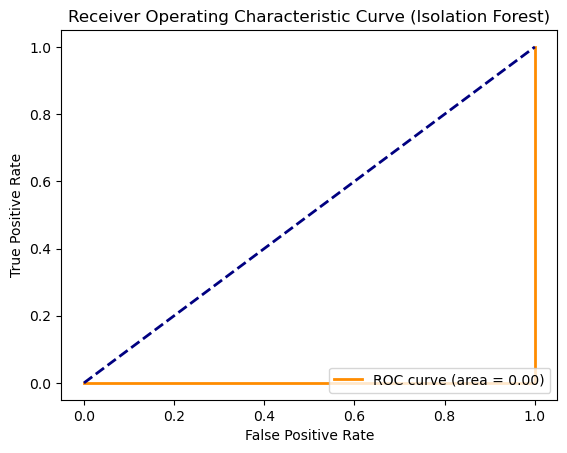

In [21]:
# Assuming 'clf_isoforest' is your trained Isolation Forest model and 'X_test' is your testing data
# Calculate decision scores for Isolation Forest
decision_scores_isoforest = -clf_isoforest.decision_function(X_test)

# Calculate ROC-AUC and Precision-Recall scores for Isolation Forest
fpr, tpr, _ = roc_curve(anomalies_test_isoforest, decision_scores_isoforest)
roc_auc = auc(fpr, tpr)

precision, recall, _ = precision_recall_curve(anomalies_test_isoforest, decision_scores_isoforest)
avg_precision = average_precision_score(anomalies_test_isoforest, decision_scores_isoforest)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve (Isolation Forest)')
plt.legend(loc='lower right')
plt.show()

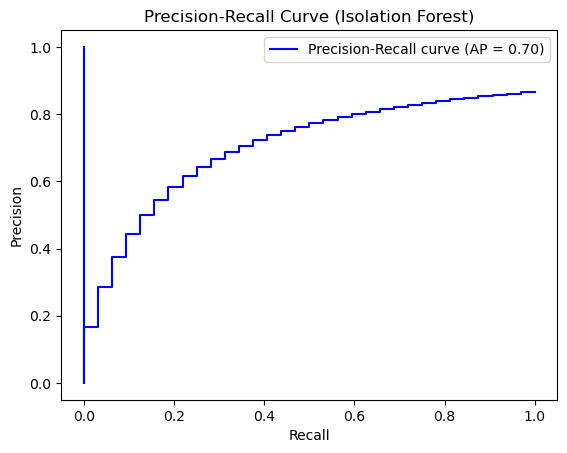

In [22]:
# Plot Precision-Recall curve
plt.figure()
plt.step(recall, precision, color='b', where='post', label=f'Precision-Recall curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Isolation Forest)')
plt.legend(loc='upper right')
plt.show()

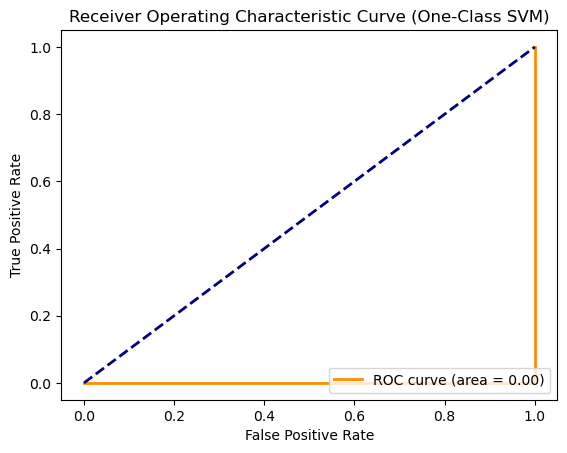

In [23]:
# Assuming 'clf_oneclasssvm' is your trained One-Class SVM model and 'X_test' is your testing data
# Calculate decision scores for One-Class SVM
decision_scores_oneclasssvm = -clf_oneclasssvm.decision_function(X_test)

# Calculate ROC-AUC and Precision-Recall scores for One-Class SVM
fpr, tpr, _ = roc_curve(anomalies_test_oneclasssvm, decision_scores_oneclasssvm)
roc_auc = auc(fpr, tpr)

precision, recall, _ = precision_recall_curve(anomalies_test_oneclasssvm, decision_scores_oneclasssvm)
avg_precision = average_precision_score(anomalies_test_oneclasssvm, decision_scores_oneclasssvm)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve (One-Class SVM)')
plt.legend(loc='lower right')
plt.show()

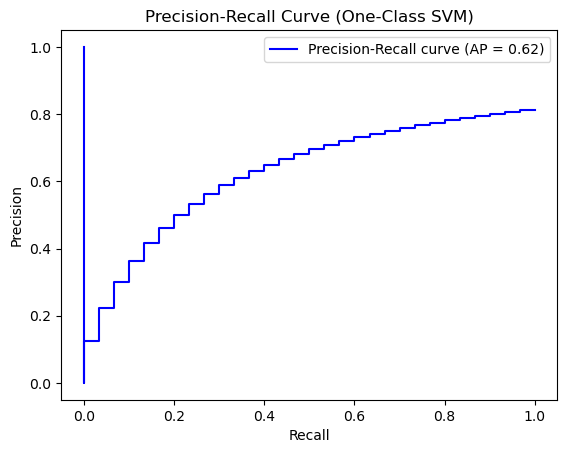

In [26]:
# Plot Precision-Recall curve
plt.figure()
plt.step(recall, precision, color='b', where='post', label=f'Precision-Recall curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (One-Class SVM)')
plt.legend(loc='upper right')
plt.show()